# Generate a simulation of a SED including atmsopheric effect and detector effect


- Author : Sylvie Dagoret-Campagne
- Date of creation :  July 9th 2016


- Original SED can be found here :

ftp://ftp.stsci.edu/cdbs/current_calspec/



In [228]:
import numpy as np

%config InlineBackend.rc = {}
import matplotlib
matplotlib.rc_file("../templates/matplotlibrc")

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd


In [229]:
from astropy.io import fits

In [230]:
import os

In [231]:
from scipy.interpolate import UnivariateSpline

## Calspec SED

In [232]:
path_sed='calspec'
basefile_sed='hd163466_stis_003.fits'
obj_name='hd163466'
airmass='1.1'
night_name='20160509-y3'

In [233]:
file_sed=os.path.join(path_sed,basefile_sed)

In [234]:
hdulist=fits.open(file_sed)
#hdulist.info()

In [235]:
table_data=hdulist[1].data

In [236]:
wavelength_sed=(table_data.field('WAVELENGTH'))/10.   # convert the wavelength into nm
flux_sed=table_data.field('FLUX')

In [237]:
selected_indexes=np.where(np.logical_and(wavelength_sed>=0, wavelength_sed<1200.))

In [238]:
wavelength_sed=wavelength_sed[selected_indexes]
flux_sed=flux_sed[selected_indexes]

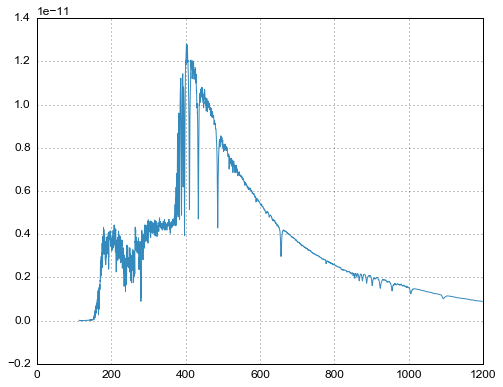

In [239]:
plt.plot(wavelength_sed,flux_sed)
#plt.xlim(0.,1000.)

## CCD

In [240]:
path_ccd='detectoreffect'
basefile_ccd='transmissions-LSST.dat'

In [241]:
file_ccd=os.path.join(path_ccd,basefile_ccd)

In [242]:
df=pd.read_csv(file_ccd,names=['wl','Topt','Tccd','U','G','R','I','Z','Y4','atm'],sep='\t')

In [243]:
wavelength_ccd=df['wl']
efficiency_ccd=df['Tccd']/100.
transmission_opt=df['Topt']/100.

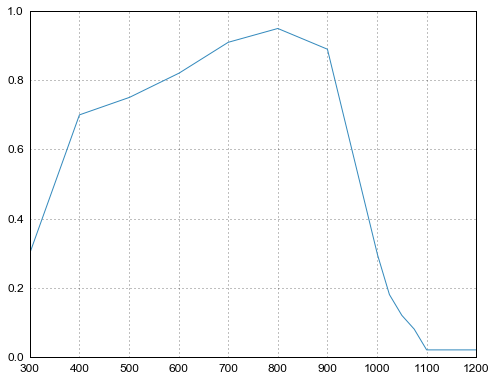

In [244]:
plt.plot(wavelength_ccd,efficiency_ccd)

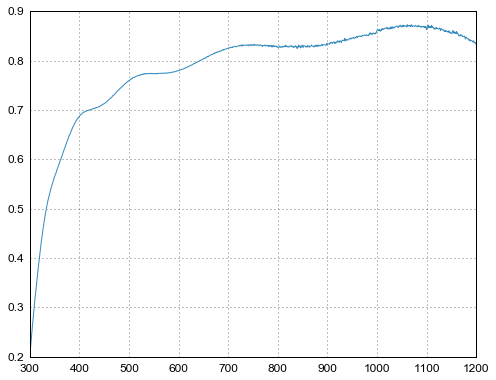

In [245]:
plt.plot(wavelength_ccd,transmission_opt)

### fonction to get the CCT efficiency at anly wavelenth

- Interpolation

In [246]:
wavelength_to_TCCD_spl=UnivariateSpline(wavelength_ccd,efficiency_ccd)

## TOps

## Atmosphere

In [247]:
index=1 # z=1.1

In [1]:
path_atm='libradtran/monocam_2016-05-09-y3/afglus'
root_file='UVSPEC_REPTRAN_SOLAR_ALT22_COARSE_'
pre_file='pwv80_'
ext_file='.out'

In [249]:
basefile_atm=root_file+pre_file+str(index)+ext_file

In [250]:
file_atm=os.path.join(path_atm,basefile_atm)

In [251]:
atm_array=np.loadtxt(file_atm)
wavelength_atm=atm_array[:,0] # in nm
transmission_atm=atm_array[:,1]

In [252]:
selected_indexes=np.where(np.logical_and(wavelength_atm>=0, wavelength_atm<1000.))

In [253]:
wavelength_atm=wavelength_atm[selected_indexes]
transmission_atm=transmission_atm[selected_indexes]

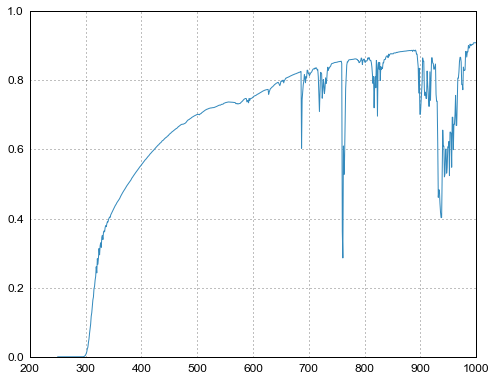

In [254]:
plt.plot(wavelength_atm,transmission_atm)

### Interpolation

In [255]:
wavelength_to_TATM_spl=UnivariateSpline(wavelength_atm,transmission_atm)

## Compute transmissions

In [256]:
wavelength_sed.shape

(3794,)

In [257]:
wavelength_atm.shape

(750,)

In [258]:
wavelength_ccd.shape

(901,)

In [259]:
#TCCD=wavelength_to_TCCD_spl(wavelength_sed)
TCCD=np.interp(wavelength_sed,wavelength_ccd,efficiency_ccd)

In [260]:
TOPT=np.interp(wavelength_sed,wavelength_ccd,transmission_opt)

In [261]:
#TATM=wavelength_to_TATM_spl(wavelength_sed)
TATM=np.interp(wavelength_sed,wavelength_atm,transmission_atm)

(0.0, 1.0)

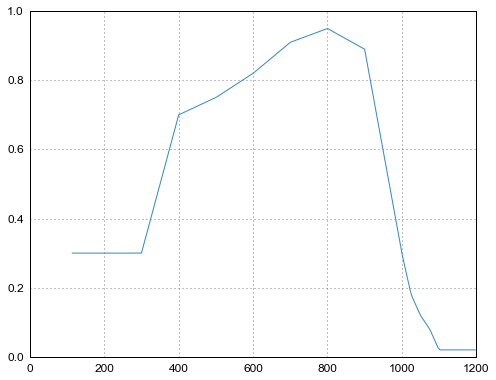

In [262]:
plt.plot(wavelength_sed,TCCD)
plt.xlim(0.,1200.)
plt.ylim(0.,1.)

(0.0, 1200.0)

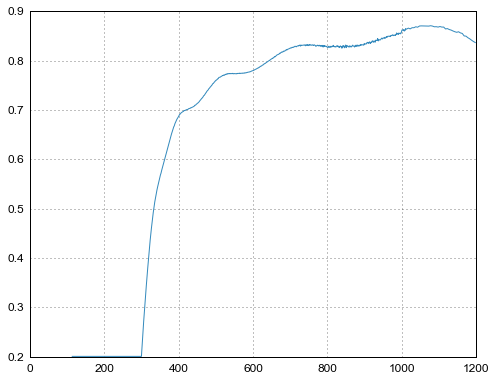

In [263]:
plt.plot(wavelength_sed,TOPT)
plt.xlim(0.,1200.)
#plt.ylim(0.,1.)

(0.0, 1.0)

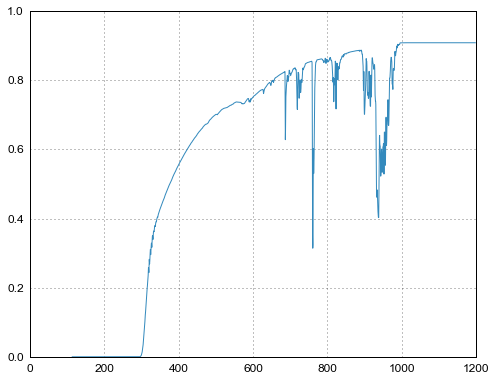

In [264]:
plt.plot(wavelength_sed,TATM)
plt.xlim(0.,1200.)
plt.ylim(0.,1.)

### Filters Y3 and Y4

In [265]:
file_design='detectoreffect/FilterFinalDesignSpreadsheet23DEC2010_V1_SDC2016.xls'

In [266]:
y3_selected_cols=[2,3,4,4,6,7,8,9,10]
y3_header=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]

#### Y3

In [267]:
dfy3=pd.read_excel(open(file_design,'rb'), sheetname=6,parse_cols=y3_selected_cols,skiprows=y3_header)

In [268]:
#dfy3.head()

In [269]:
wl_y3=dfy3['Wavelength (nm)']
flt_y3=dfy3['y3 Filter Mean Transmission over centered 10nm interval (%)']

In [270]:
flt_y3=flt_y3/100.

In [271]:
TY3=np.interp(wavelength_sed,wl_y3,flt_y3)

#### Y4

In [272]:
y4_selected_cols=[2,3,4,4,6,7,8,9,10]
y4_header=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]

In [273]:
dfy4=pd.read_excel(open(file_design,'rb'), sheetname=7,parse_cols=y4_selected_cols,skiprows=y4_header)

In [274]:
#dfy4.head()

In [275]:
wl_y4=dfy4['Wavelength (nm)']
flt_y4=dfy4['y4 Filter Mean Transmission over centered 10nm interval (%)']

In [276]:
flt_y4=flt_y4/100.

In [277]:
TY4=np.interp(wavelength_sed,wl_y4,flt_y4)

## Gather all prediction

In [278]:
SED1=flux_sed
SED2=flux_sed*TCCD
SED3=flux_sed*TCCD*TATM
SED4=flux_sed*TCCD*TATM*TOPT
SED5=flux_sed*TCCD*TATM*TOPT*TY3
SED6=flux_sed*TCCD*TATM*TOPT*TY4

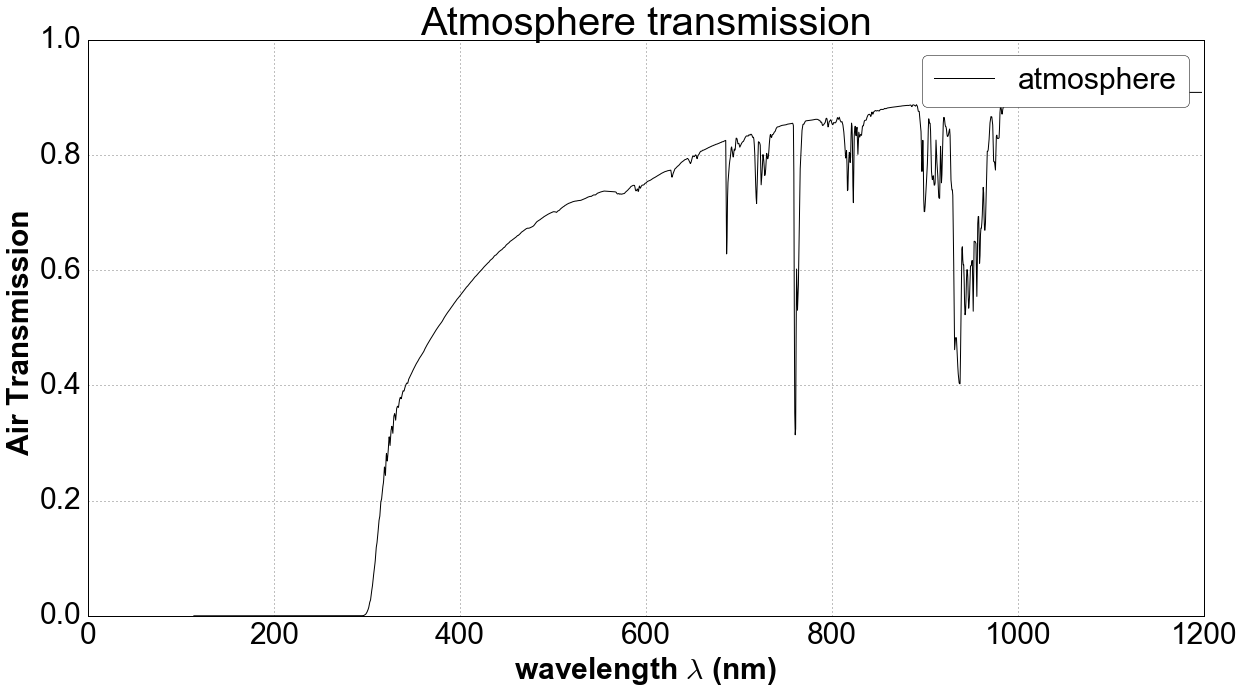

In [279]:
plt.figure(figsize=(20,10))
plt.plot(wavelength_sed,TATM,label='atmosphere',color='k')
plt.xlim(0,1200.)
plt.ylim(0,1.)
plt.title('Atmosphere transmission',fontsize=40)
plt.xlabel('wavelength $\lambda$ (nm)',fontsize=30)
plt.ylabel('Air Transmission ',fontsize=30)
plt.tick_params(axis='x', labelsize=30)
plt.tick_params(axis='y', labelsize=30)
plt.legend(fontsize=30)
plt.show()

## Plot the three SED

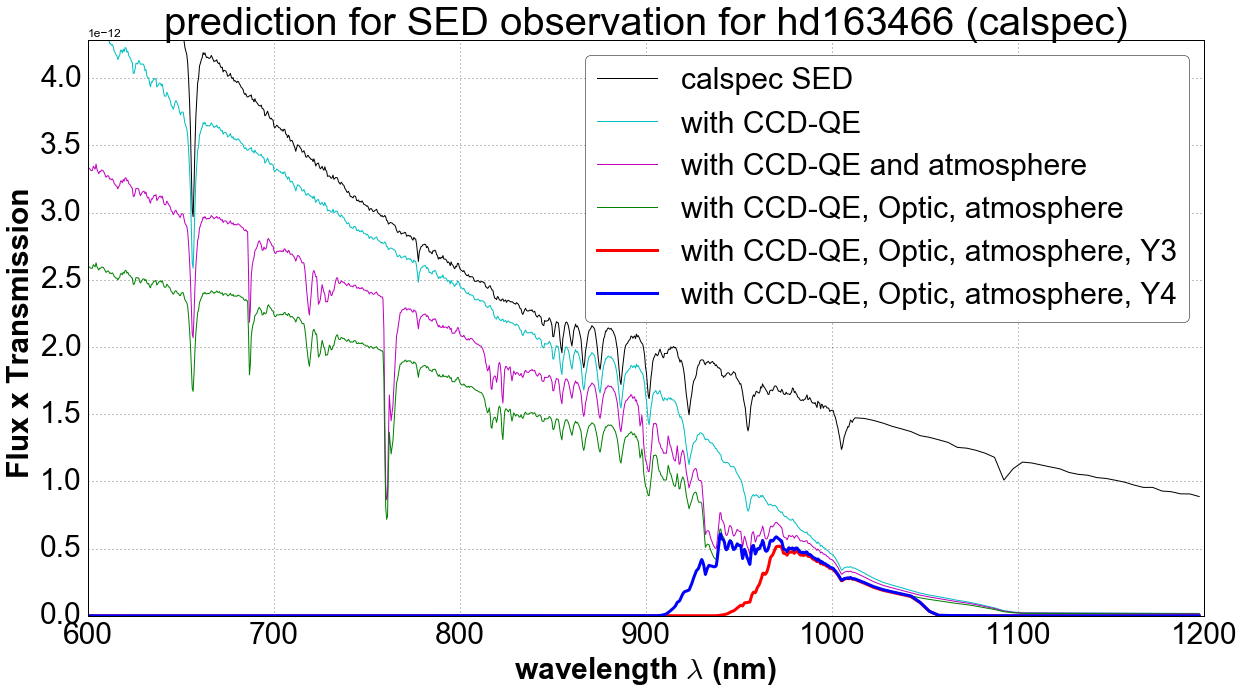

In [280]:
plt.figure(figsize=(20,10))
plt.plot(wavelength_sed,SED1,label='calspec SED',color='k')
plt.plot(wavelength_sed,SED2,label='with CCD-QE',color='c')
plt.plot(wavelength_sed,SED3,label='with CCD-QE and atmosphere',color='m')
plt.plot(wavelength_sed,SED4,label='with CCD-QE, Optic, atmosphere',color='g')
plt.plot(wavelength_sed,SED5,label='with CCD-QE, Optic, atmosphere, Y3',color='r',linewidth=3)
plt.plot(wavelength_sed,SED6,label='with CCD-QE, Optic, atmosphere, Y4',color='b',linewidth=3)
plt.xlim(600,1200.)
plt.ylim(0,1.2*SED4.max())
plt.title('prediction for SED observation for hd163466 (calspec)',fontsize=40)
plt.xlabel('wavelength $\lambda$ (nm)',fontsize=25)
plt.ylabel('Flux x Transmission ',fontsize=25)
plt.tick_params(axis='x', labelsize=25)
plt.tick_params(axis='y', labelsize=25)
plt.legend(loc='best',fontsize=20)
plt.show()


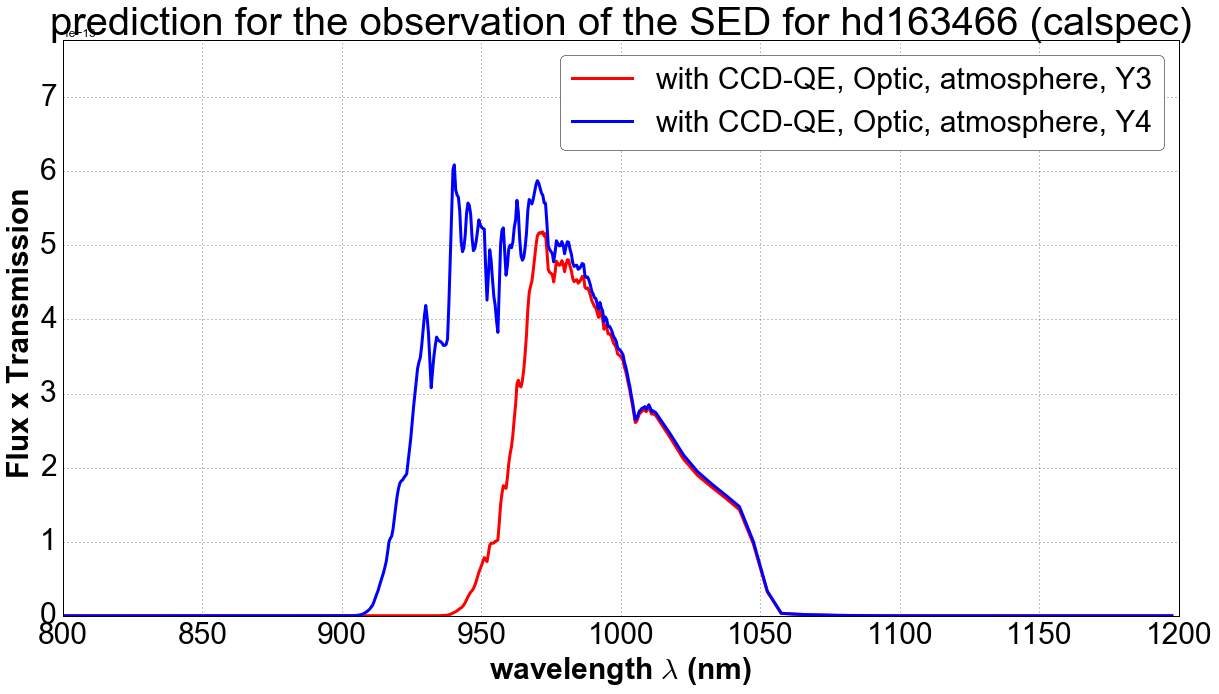

In [281]:
plt.figure(figsize=(20,10))
plt.plot(wavelength_sed,SED5,label='with CCD-QE, Optic, atmosphere, Y3',color='r',linewidth=3)
plt.plot(wavelength_sed,SED6,label='with CCD-QE, Optic, atmosphere, Y4',color='b',linewidth=3)
plt.xlim(800,1200.)
plt.ylim(0,SED5.max()*1.5)
plt.title('prediction for the observation of the SED for hd163466 (calspec) in Y3/Y4',fontsize=30)
plt.xlabel('wavelength $\lambda$ (nm)',fontsize=30)
plt.ylabel('Flux x Transmission ',fontsize=30)
plt.tick_params(axis='x', labelsize=25)
plt.tick_params(axis='y', labelsize=25)
plt.legend(loc='best',fontsize=20)
plt.show()

## Save spectra in a fits file

In [282]:
tablefitsfile='SEDPred_'+obj_name+'_'+night_name+'_'+str(index)+'.fits'
print(tablefitsfile)

SEDPred_hd163466_20160509-y3_1.fits


In [283]:
prim_hdr=fits.Header()
prim_hdr['OBJ_NAME']=obj_name
prim_hdr['AIRMASS']=airmass
prim_hdr['UNITS']='wavelength in nm'
prim_hdr['COMMENT']="Prediction of observable SED"
primhdu=fits.PrimaryHDU(header=prim_hdr)

In [284]:
col1 = fits.Column(name='WAVELENGTH', format='E', array=wavelength_sed)
col2 = fits.Column(name='SEDcalspec', format='E', array=SED1)
col3 = fits.Column(name='SEDxQE', format='E', array=SED2)
col4 = fits.Column(name='SEDxQExATM', format='E', array=SED3)
col5 = fits.Column(name='SEDxQExATMxTopt', format='E', array=SED4)
col6 = fits.Column(name='SEDxQExATMxToptxY3', format='E', array=SED5)
col7 = fits.Column(name='SEDxQExATMxToptxY4', format='E', array=SED6)

In [285]:
cols = fits.ColDefs([col1, col2,col3,col4,col5,col6,col7])     # definition of the columns

In [286]:
tbhdu = fits.BinTableHDU.from_columns(cols)     # new binary table HDU

In [287]:
thdulist = fits.HDUList([primhdu, tbhdu])

In [288]:
thdulist.writeto(tablefitsfile,clobber=True)

In [289]:
tablefitsfile

'SEDPred_hd163466_20160509-y3_1.fits'

## To read the file

In [290]:
# example to read a file
fileindex=index
path_sed='../SED'
obj_name_sed='hd163466-y3'
 

# get the content of the file
hdulist=fits.open(tablefitsfile)
hdulist.info()

table_data=hdulist[1].data
table_data.columns  # shows the columns names of the table

    # retrieve the table inside SED file

vavelength_sed=table_data.field('WAVELENGTH')
flux_sed=table_data.field('SEDcalspec')
flux_sedccd=table_data.field('SEDxQE')
flux_sedccdatm=table_data.field('SEDxQExATM')
flux_sedccdatmopt=table_data.field('SEDxQExATMxTopt')
flux_sedccdatmopty3=table_data.field('SEDxQExATMxToptxY3')
flux_sedccdatmopty4=table_data.field('SEDxQExATMxToptxY4')

  

Filename: SEDPred_hd163466_20160509-y3_1.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       8   ()              
1                BinTableHDU     22   3794R x 7C   [E, E, E, E, E, E, E]   
